## Data

In [16]:
from libs.paths import PATHS
from libs.pre_processing.training_data import read_data, train_test_split
from libs.pre_processing.pipeline import make_pipeline

In [17]:
# Oversampling
from imblearn.over_sampling import SMOTE

smote = SMOTE(
    sampling_strategy=1,  
    k_neighbors=5,             
    random_state=42            
)

In [18]:
# Raw data
X, y = read_data(PATHS["ADULT_INCOME"], "income")

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)

# Pre-processed data
pipeline = make_pipeline(X_train)
X_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

# Balanced data
X_balanced, y_balanced = smote.fit_resample(X_transformed, y_train)

## Flaml

In [19]:
from flaml import AutoML

ONE_HOUR = 3600  # seconds

automl = AutoML()

automl_settings = {
    "time_budget": ONE_HOUR,  
    "metric": "roc_auc",
    "task": 'classification',
    "verbose": 1,
    "n_splits": 10,
}

automl_settings_weighted = {
    "time_budget": ONE_HOUR, 
    "metric": "roc_auc_weighted",
    "task": 'classification',
    "verbose": 1,
    "n_splits": 10,
}

In [20]:
from sklearn.metrics import classification_report, roc_auc_score

class ModelResults:
    automl: AutoML
    report: str
    roc_auc: float
    y_pred_proba: list

    def __init__(self, automl, report, roc_auc, y_pred_proba):
        self.automl = automl
        self.report = report
        self.roc_auc = roc_auc
        self.y_pred_proba = y_pred_proba

def run_automl(X, y, settings, X_test = X_test):
    automl.fit(X, y, **settings)

    y_pred = automl.predict(X_test)
    y_pred_proba = automl.predict_proba(X_test)
    
    report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    
    return ModelResults(automl, report, roc_auc, y_pred_proba)

### Results

In [21]:
# Raw data results
raw_results = run_automl(X_train, y_train, automl_settings)

In [22]:
print("Best hyperparameters found: ", raw_results.automl.best_config)
print("Best model: ", raw_results.automl.model.estimator)
print("Best score: ", raw_results.automl.metrics_for_best_config)

print("Raw Data Results:")
print(raw_results.report)
print(f"ROC AUC: {raw_results.roc_auc:.4f}")

Best hyperparameters found:  {'n_estimators': 915, 'max_depth': 4, 'min_child_weight': np.float64(0.010583376194399485), 'learning_rate': np.float64(0.0578859614591954), 'subsample': 1.0, 'colsample_bylevel': 1.0, 'colsample_bytree': np.float64(0.443227298776447), 'reg_alpha': np.float64(0.005594721266371519), 'reg_lambda': np.float64(0.049505787843246794)}
Best model:  XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=1.0, colsample_bynode=None,
              colsample_bytree=np.float64(0.443227298776447), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None,
              learning_rate=np.float64(0.0578859614591954), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
  

In [23]:
# Pre-processed data results
pp_results = run_automl(X_transformed, y_train, automl_settings, X_test_transformed)

c:\Users\Alvaro Lima\miniconda3\envs\flaml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Alvaro Lima\miniconda3\envs\flaml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Alvaro Lima\miniconda3\envs\flaml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Alvaro Lima\miniconda3\envs\flaml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Alvaro Lima\miniconda3\envs\flaml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMCla

In [24]:
print("Best hyperparameters found: ", pp_results.automl.best_config)
print("Best model: ", pp_results.automl.model.estimator)
print("Best score: ", pp_results.automl.metrics_for_best_config)

print("Raw Data Results:")
print(pp_results.report)
print(f"ROC AUC: {pp_results.roc_auc:.4f}")

Best hyperparameters found:  {'n_estimators': 512, 'num_leaves': 32, 'min_child_samples': 17, 'learning_rate': np.float64(0.03419085568340278), 'log_max_bin': 8, 'colsample_bytree': np.float64(0.291367976595499), 'reg_alpha': 0.0009765625, 'reg_lambda': np.float64(0.2801054993390511)}
Best model:  LGBMClassifier(colsample_bytree=np.float64(0.291367976595499),
               learning_rate=np.float64(0.03419085568340278), max_bin=255,
               min_child_samples=17, n_estimators=512, n_jobs=-1, num_leaves=32,
               reg_alpha=0.0009765625,
               reg_lambda=np.float64(0.2801054993390511), verbose=-1)
Best score:  (np.float64(0.07070926940071125), {'pred_time': 1.0578280096076156e-05})
Raw Data Results:
              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92     11233
        >50K       0.78      0.67      0.72      3420

    accuracy                           0.88     14653
   macro avg       0.84      0.81      0.82     146

In [25]:
# Balanced data results
balanced_results = run_automl(X_balanced, y_balanced, automl_settings, X_test_transformed)

c:\Users\Alvaro Lima\miniconda3\envs\flaml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Alvaro Lima\miniconda3\envs\flaml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Alvaro Lima\miniconda3\envs\flaml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Alvaro Lima\miniconda3\envs\flaml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Alvaro Lima\miniconda3\envs\flaml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMCla

In [26]:
print("Best hyperparameters found: ", balanced_results.automl.best_config)
print("Best model: ", balanced_results.automl.model.estimator)
print("Best score: ", balanced_results.automl.metrics_for_best_config)

print("Raw Data Results:")
print(balanced_results.report)
print(f"ROC AUC: {balanced_results.roc_auc:.4f}")

Best hyperparameters found:  {'n_estimators': 589, 'num_leaves': 81, 'min_child_samples': 10, 'learning_rate': np.float64(0.04179074535827166), 'log_max_bin': 10, 'colsample_bytree': np.float64(0.6578347391758362), 'reg_alpha': np.float64(0.007704104902643935), 'reg_lambda': np.float64(0.020229013206102948)}
Best model:  LGBMClassifier(colsample_bytree=np.float64(0.6578347391758362),
               learning_rate=np.float64(0.04179074535827166), max_bin=1023,
               min_child_samples=10, n_estimators=589, n_jobs=-1, num_leaves=81,
               reg_alpha=np.float64(0.007704104902643935),
               reg_lambda=np.float64(0.020229013206102948), verbose=-1)
Best score:  (np.float64(0.024613554670828153), {'pred_time': 1.8550820060319412e-05})
Raw Data Results:
              precision    recall  f1-score   support

       <=50K       0.91      0.92      0.92     11233
        >50K       0.74      0.72      0.73      3420

    accuracy                           0.87     14653
  

In [27]:
# Balanced data results
w_results = run_automl(X_transformed, y_train, automl_settings_weighted, X_test_transformed)

c:\Users\Alvaro Lima\miniconda3\envs\flaml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Alvaro Lima\miniconda3\envs\flaml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Alvaro Lima\miniconda3\envs\flaml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Alvaro Lima\miniconda3\envs\flaml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Alvaro Lima\miniconda3\envs\flaml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMCla

In [28]:
print("Best hyperparameters found: ", w_results.automl.best_config)
print("Best model: ", w_results.automl.model.estimator)
print("Best score: ", w_results.automl.metrics_for_best_config)

print("Raw Data Results:")
print(w_results.report)
print(f"ROC AUC: {w_results.roc_auc:.4f}")

Best hyperparameters found:  {'n_estimators': 512, 'num_leaves': 32, 'min_child_samples': 17, 'learning_rate': np.float64(0.03419085568340278), 'log_max_bin': 8, 'colsample_bytree': np.float64(0.291367976595499), 'reg_alpha': 0.0009765625, 'reg_lambda': np.float64(0.2801054993390511)}
Best model:  LGBMClassifier(colsample_bytree=np.float64(0.291367976595499),
               learning_rate=np.float64(0.03419085568340278), max_bin=255,
               min_child_samples=17, n_estimators=512, n_jobs=-1, num_leaves=32,
               reg_alpha=0.0009765625,
               reg_lambda=np.float64(0.2801054993390511), verbose=-1)
Best score:  (np.float64(0.07070926940071125), {'pred_time': 9.995808083676654e-06})
Raw Data Results:
              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92     11233
        >50K       0.78      0.67      0.72      3420

    accuracy                           0.88     14653
   macro avg       0.84      0.81      0.82     1465

### Curves

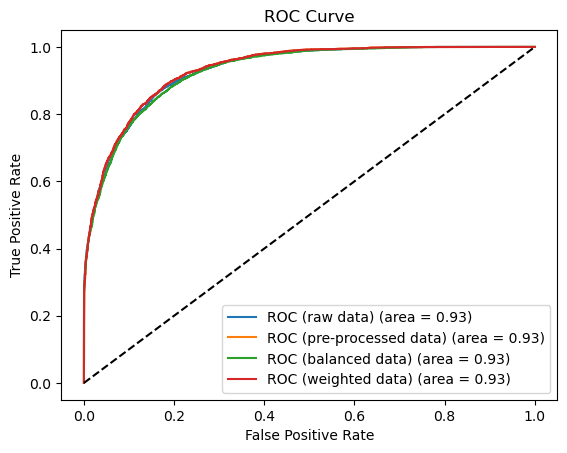

In [29]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_test_bin = (y_test == '>50K').astype(int)

# Plotando a curva ROC
fpr1, tpr1, thresholds1 = roc_curve(y_test_bin, raw_results.y_pred_proba[:, 1])
fpr2, tpr2, thresholds2 = roc_curve(y_test_bin, pp_results.y_pred_proba[:, 1])
fpr3, tpr3, thresholds3 = roc_curve(y_test_bin, balanced_results.y_pred_proba[:, 1])
fpr4, tpr4, thresholds4 = roc_curve(y_test_bin, w_results.y_pred_proba[:, 1])

plt.figure()
plt.plot(fpr1, tpr1, label=f'ROC (raw data) (area = {raw_results.roc_auc:.2f})')
plt.plot(fpr2, tpr2, label=f'ROC (pre-processed data) (area = {pp_results.roc_auc:.2f})')
plt.plot(fpr3, tpr3, label=f'ROC (balanced data) (area = {balanced_results.roc_auc:.2f})')
plt.plot(fpr4, tpr4, label=f'ROC (weighted data) (area = {w_results.roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()